# Automatizované určenie závažnosti dopravnej nehody


*Autori: Bc. Jakub Juško, Bc. Lukáš Radoský*

Kvalitné riešenie dopravy môže signifikantne ovplyvniť ekonomickú dynamiku prostredia [1]. Dopravné nehody, v závislosti od ich závažnosti, môžu ovplyvniť tok dopravy, a dominovým efektom tak zasiahnuť až do ekonomiky. Hoci infraštruktúra dopravy by mala byť nastavená tak, aby sa nehodám predišlo a aby bolo možné ich dôsledky minimalizovať, úplne im zabrániť nie je možné. Okrem toho, subjekty s dopravnou infraštruktúrou, ako napríklad mestá, typicky disponujú obmedzenými zdrojmi. Nehodám teda v reálnom prostredí nie je možné predísť.

Praktickejšou možnosťou je pokúsiť sa minimalizovať dôsledky nehôd. Tieto dôsledky môžu byť ekonomické, ako už bolo uvedené, avšak tiež môžu viesť k úmrtiam (zdržanie sanitky so súrnym prípadom) alebo škodám na osobnom živote (zmeškanie svatby, pohrebu a pod.). Najefektívnejším prístupom je čo najrýchlejšie odstránenie prekážok vzniknutých nehodou (napr. vrak auta). Aj v tomto prípade však reálny subjekt disponuje obmedzenými zdrojmi.

Pokúsme sa preto presunúť zodpovednosť na tých, ktorí sú ovplyvnení nehodou. Doprava, a v konečnom dôsledku aj ekonomika, sa prestanú spoliehať na infraštruktúru. Namiesto toho prispôsobia svoje konanie existencii nehody napríklad tak, že včas zvolia optimálnejšiu trasu. Na to však potrebujú disponovať informáciou o nehode a vedieť vyhodnotiť jej vplyv na dopravu. Vyhodnotenie vplyvu nehody na dopravu však môže byť netriviálne. Je preň potrebné poznať množstvo faktorov súvisiacich s nehodou.

Pre zainteresovaných by teda bolo ideálne, aby informáciu o nehode obdržali už spolu s jej závažnosťou. Na to je potrebné vytvoriť mechanizmus, ktorý by dokázal nehode priradiť ohodnotenie jej závažnosti. Práve takýto mechanizmus sa pokúsime vytvoriť v rámci tohto projektu. Vstupom pre náš model budú údaje o nehode, výstupom bude ohodnotenie závažnosti nehody. Úlohu budeme riešiť ako **klasifikáciu**, avšak je možné ju pretransformovať na regresiu, čo sa v neskorších fázach projektu môže ukázať ako vhodnejšie.

Sledovanou **závislou premennou** je teda závažnosť nehody (atribút Severity). Atribút vnímame ako kategorický, pričom dataset obsahuje 4 kategórie. Bližšie sa ju opisujeme v analýze dát.

## Revízie dokumentu

### Odovzdanie č.1


Dátum: 21.03.2020

Ciele odovzdania:
*   Identifikácia úlohy, definovanie problému
*   Analýza dát, identifikácia problémov
*   Predpokladaný scenár riešenia

Podiel práce:
*   **Jakub Juško**: 50%
*   **Lukáš Radoský**: 50%



#Analýza dát




Pre trénovanie modelu využijeme dataset *US Accidents* [2].

## Import knižníc a načítanie dát


In [0]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns


### Zmena konfigurácie figur


In [0]:
plt.rcParams["figure.figsize"] = (16,8)
pd.options.display.float_format = '{:,.2f}'.format

### Načítanie dát

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/US_Accidents_Dec19.csv"
df = pd.read_csv(path)

## Opis dát

Pozrime sa, koľko záznamov a atribútov sa nachádza v datasete.

In [0]:
print("Počet záznamov: {}.\nPočet atribútov: {}.".format(*df.shape))

Počet záznamov: 2974335.
Počet atribútov: 49.


Pre ilustráciu zobrazujeme ukážku niekoľkých záznamov z datasetu.

In [0]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.00,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.87,-84.06,nan,nan,0.01,Right lane blocked due to accident on I-70 Eas...,nan,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.90,nan,91.00,29.68,10.00,Calm,nan,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.00,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.93,-82.83,nan,nan,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,"2,584.00",Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.90,nan,100.00,29.65,10.00,Calm,nan,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.00,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.06,-84.03,nan,nan,0.01,Accident on OH-32 State Route 32 Westbound at ...,nan,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.00,33.30,100.00,29.67,10.00,SW,3.50,nan,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.00,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.75,-84.21,nan,nan,0.01,Accident on I-75 Southbound at Exits 52 52B US...,nan,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.10,31.00,96.00,29.64,9.00,SW,4.60,nan,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.00,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.63,-84.19,nan,nan,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,nan,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.00,33.30,89.00,29.65,6.00,SW,3.50,nan,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


Pre každý atribút (okrem numerických) si uvádzame jeho základné vlastnosti. Medzi ne patria počet záznamov, ktoré majú pre daný atribút uvedenú hodnotu, počet unikátnych hodnôt daného atribútu, najčastejšia hodnota daného atribútu a počet jej výskytov v záznamoch. Vybrané atribúty opíšeme podrobnejšie neskôr.

In [0]:
df.describe(exclude=np.number)

,ID,Source,Start_Time,End_Time,Description,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,2974335,2974335,2974335,2974335,2974334,2974335,2974335,2974252,2974335,2974335,2973455,2974335,2971172,2968644,2937630,2929234,2908403,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974335,2974242,2974242,2974242,2974242
unique,2974335,3,2743101,2761499,1597506,160715,3,11685,1713,49,377152,1,4,1995,470781,24,120,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2
top,A-104015,MapQuest,2017-05-15 09:22:55,2017-05-15 15:22:55,At I-15 - Accident.,I-5 N,R,Houston,Los Angeles,CA,91706,US,US/Eastern,KMCJ,2019-09-17 07:53:00,Calm,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
freq,1,2204098,74,73,1212,34693,2438139,93289,227180,663204,4646,2974335,1277187,56778,267,368268,808171,2939115,2973881,2766745,2966708,2735888,2970940,2949174,2974167,2917922,2934175,2973224,2470952,2974335,2194084,2342592,2492085,2604005


Tu uvádzame základné vlastnosti numerických atribútov. Táto tabuľka však slúži skôr len ako referenčná, keďže z nej priamo nič nemožno vyčítať. Zaujímavé atribúty popisujeme podrobnejšie nižšie.

In [0]:
df.describe(include=np.number)

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,"2,246,264.00","2,974,335.00","2,974,335.00","2,974,335.00","728,071.00","728,071.00","2,974,335.00","1,056,730.00","2,918,272.00","1,121,712.00","2,915,162.00","2,926,193.00","2,908,644.00","2,533,495.00","975,977.00"
mean,207.83,2.36,36.49,-95.43,37.58,-99.98,0.29,"5,837.00",62.35,51.33,65.41,29.83,9.15,8.30,0.02
std,20.33,0.54,4.92,17.22,5.00,18.42,1.55,"15,159.28",18.79,25.19,22.56,0.72,2.89,5.14,0.24
min,200.00,1.00,24.56,-124.62,24.57,-124.50,0.00,0.00,-77.80,-65.90,1.00,0.00,0.00,0.00,0.00
25%,201.00,2.00,33.55,-117.29,33.96,-118.29,0.00,837.00,50.00,32.00,49.00,29.82,10.00,4.60,0.00
50%,201.00,2.00,35.85,-90.25,37.90,-96.63,0.00,"2,717.00",64.40,54.00,67.00,29.98,10.00,7.00,0.00
75%,201.00,3.00,40.37,-80.92,41.37,-82.32,0.01,"7,000.00",76.00,73.00,84.00,30.11,10.00,10.40,0.00
max,406.00,4.00,49.00,-67.11,49.08,-67.11,333.63,"9,999,997.00",170.60,115.00,100.00,33.04,140.00,822.80,25.00


V datasete sa vyskytuje atribút ID. Tento atribút má rovnaký počet unikátnych hodnôt ako je celkový počet záznamov v datasete preto ho môžeme odstrániť (duplicitná informácia ako index) a ďalej ho neuvažovať.

In [0]:
df = df.drop('ID', 1)

Pre atribúty je vhodné poznať aj ich typy.

In [0]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Columns: 48 entries, Source to Astronomical_Twilight
dtypes: bool(13), float64(14), int64(1), object(20)
memory usage: 831.1+ MB


Vidíme, že dataset obsahuje 13 atribútov typu boolean, 14 atribútov typu float a 1 atribút typu typu integer. Ak bude potrebné pracovať len s podmnožinou záznamov datasetu, optimalizovať výber podmnožiny tak, aby rozdelenie hodnôt atribútov v nej bolo primerané, bude v prípade atribútov typu boolean jednoduché, nakoľko nadobúdajú len 2 rôzne hodnoty. U ďalších atribútov to bude náročnejšie.

Typu "object" je 20 atribútov datasetu. "Object" predstavuje typ string, ktorý nie je bližšie špecifikovaný. Spadá sem napríklad aj dátum/čas. Pozrime sa preto podrobnejšie na atribúty tohto typu (uvádzaná tabuľka podmnožinou referenčnej tabuľky nenumerických atribútov uvedenej vyššie).

In [0]:
df.describe(include=np.object)

,Source,Start_Time,End_Time,Description,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,2974335,2974335,2974335,2974334,2974335,2974335,2974252,2974335,2974335,2973455,2974335,2971172,2968644,2937630,2929234,2908403,2974242,2974242,2974242,2974242
unique,3,2743101,2761499,1597506,160715,3,11685,1713,49,377152,1,4,1995,470781,24,120,2,2,2,2
top,MapQuest,2017-05-15 09:22:55,2017-05-15 15:22:55,At I-15 - Accident.,I-5 N,R,Houston,Los Angeles,CA,91706,US,US/Eastern,KMCJ,2019-09-17 07:53:00,Calm,Clear,Day,Day,Day,Day
freq,2204098,74,73,1212,34693,2438139,93289,227180,663204,4646,2974335,1277187,56778,267,368268,808171,2194084,2342592,2492085,2604005


S pomocou tejto tabuľky vieme konštatovať, že z 20 atribútov typu "object":


*   9 je kategorických atribútov s nízkym počtom kategórií (1 až 24),
*   7 je kategorických atribútov s vysokým počtom kategórií (120 až 377152),
*   3 sú atribúty typu dátum + čas,
*   1 je atribút typu string bez užšej špecifikácie formátu.


Overme si, či všetky 3 atribúty typu dátum+čas, teda Start_Time, End_Time a Weather_Timestamp dodržiavajú ten istý formát hodnôt, či už jednotlivo naprieč všetkými záznamami alebo navzájom.

In [0]:
valid_format_count_Start_time = df.Start_Time.str.match(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])').sum()
valid_format_count_End_time = df.End_Time.str.match(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])').sum()
valid_format_count_Weather_timestamp = df.Weather_Timestamp.str.match(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])').sum()

invalid_format_count_Start_time = df.Start_Time.count() - valid_format_count_Start_time
invalid_format_count_End_time = df.End_Time.count() - valid_format_count_End_time
invalid_format_count_Weather_timestamp = df.Weather_Timestamp.count() - valid_format_count_Weather_timestamp

print("Nesprávny formát atribútu Start_time má {} záznamov.".format(invalid_format_count_Start_time))
print("Neprávny formát atribútu Start_time má {} záznamov.".format(invalid_format_count_End_time))
print("Nesprávny formát atribútu Start_time má {} záznamov.".format(invalid_format_count_Weather_timestamp))

Nesprávny formát atribútu Start_time má 0 záznamov.
Neprávny formát atribútu Start_time má 0 záznamov.
Nesprávny formát atribútu Start_time má 0 záznamov.


Konštatujeme, formát *YYYY-MM-DD HH:MM:SS* je konzistentne dodržiavaný všetkými záznamami aj atribútmi. Znamená to, že tieto atribúty nebudú vyžadovať dodatočné spracovanie, a bude možné s nimi efektívne narábať. Transformácia týchto atribútov pravdaže nie je vylúčená.

In [0]:
df.isnull().sum()

Source                         0
TMC                       728071
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2246264
End_Lng                  2246264
Distance(mi)                   0
Description                    1
Number                   1917605
Street                         0
Side                           0
City                          83
County                         0
State                          0
Zipcode                      880
Country                        0
Timezone                    3163
Airport_Code                5691
Weather_Timestamp          36705
Temperature(F)             56063
Wind_Chill(F)            1852623
Humidity(%)                59173
Pressure(in)               48142
Visibility(mi)             65691
Wind_Direction             45101
Wind_Speed(mph)           440840
Precipitation(in)        1998358
Weather_Co

Ako vidíme vyššie, v niektorých stĺpcoch máme značné množstvo chýbajucich hodnôt.

### Severity - závislá premenná


Sledovanou závislou premennou, teda tou, ktorej hodnoty bude náš model predikovať, je závažnosť nehody. Nadobúda diskrétne hodnoty na stupnici 1-4, pričom 1 predstavuje najnižšiu závažnosť nehody. Na tento atribút možno nazerať ako numerický aj ako **kategorický**. Pre naše potreby o ňom zatiaľ uvažujeme ako o kategorickom.

Skúsme sa pozrieť na počet nehôd v jednotlivých štátoch.

In [0]:
states = df.State.unique()

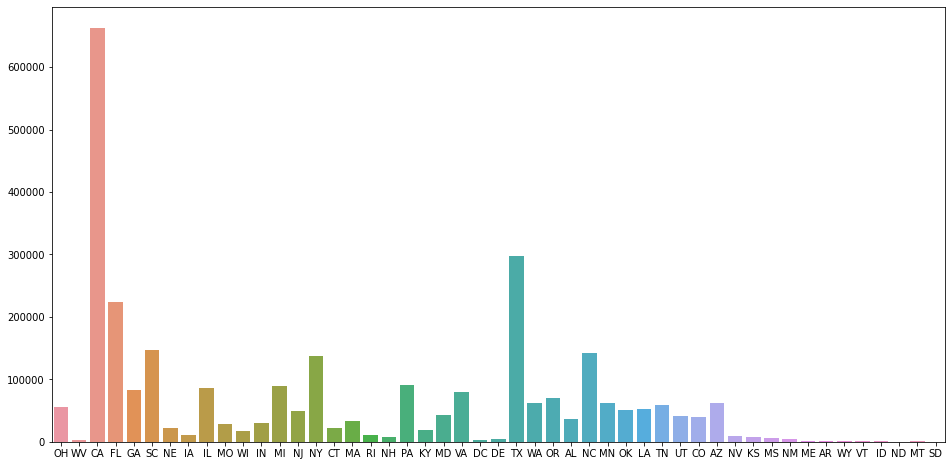

In [0]:
count_by_state=[]
for state in states:
    count_by_state.append(df[df['State']==state].count()['State'])
    
sns.barplot(states, count_by_state)

Jasne vidíme, že v Kalifornii došlo k najväčšiemu počtu nehôd.
Ďalej skontrolujme závažnosť dopravnej nehody v jednotlivých štátoch. 

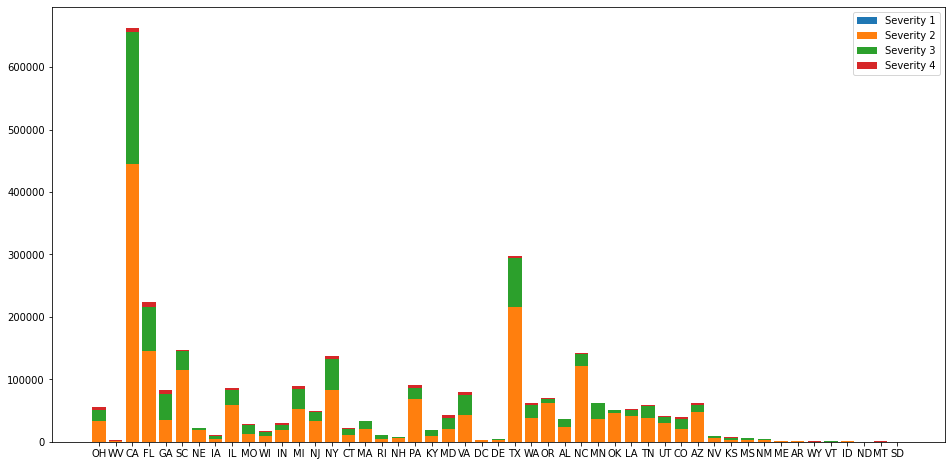

In [0]:
severity_1 = []
severity_2 = []
severity_3 = []
severity_4 = []

for state in states:
    severity_1.append(df[(df['Severity']==1)&(df['State']==state)].count()['State'])
    severity_2.append(df[(df['Severity']==2)&(df['State']==state)].count()['State'])
    severity_3.append(df[(df['Severity']==3)&(df['State']==state)].count()['State'])
    severity_4.append(df[(df['Severity']==4)&(df['State']==state)].count()['State'])

plt.bar(states, severity_1, label='Severity 1')
plt.bar(states, severity_2, label='Severity 2', bottom = severity_1)
plt.bar(states, severity_3, label='Severity 3', bottom = [i+j for i,j in zip(severity_1, severity_2)])
plt.bar(states, severity_4, label='Severity 4', bottom = [i+j+k for i,j,k in zip(severity_1, severity_2, severity_3)])
plt.legend()

Vidíme, že zastúpenie nehôd v jednotlivých štátoch je pomerne podobné medzi jednotlivými štátmi. Pozrime sa na zastúpenie v percentách u jednotlivých štátov.

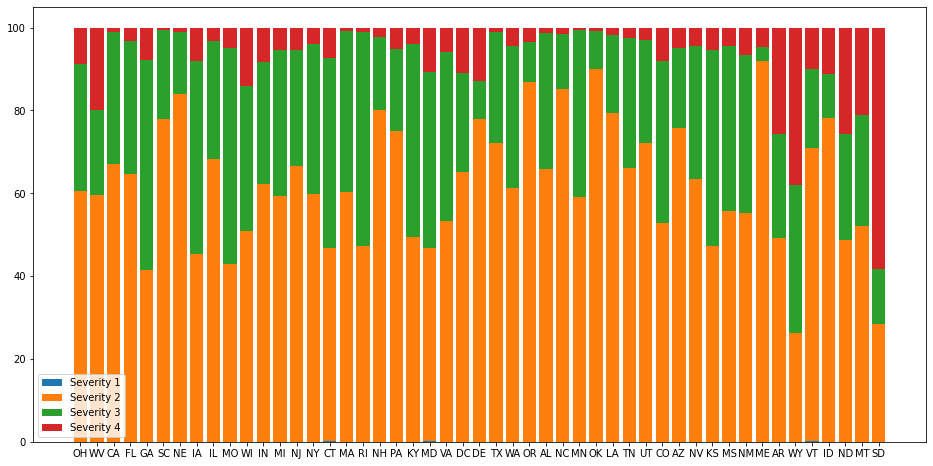

In [0]:
severity_1_n = []
severity_2_n = []
severity_3_n = []
severity_4_n = []

for state in states:
    counts = {}
    sum = 0
    for i in range(1,5):
      counts[i] = df[(df['Severity']==i)&(df['State']==state)].count()['State']
      sum += counts[i]

    severity_1_n.append(counts[1] / sum * 100)
    severity_2_n.append(counts[2] / sum * 100)
    severity_3_n.append(counts[3] / sum * 100)
    severity_4_n.append(counts[4] / sum * 100)

plt.bar(states, severity_1_n, label='Severity 1')
plt.bar(states, severity_2_n, label='Severity 2', bottom = severity_1_n)
plt.bar(states, severity_3_n, label='Severity 3', bottom = [i+j for i,j in zip(severity_1_n, severity_2_n)])
plt.bar(states, severity_4_n, label='Severity 4', bottom = [i+j+k for i,j,k in zip(severity_1_n, severity_2_n, severity_3_n)])
plt.legend()

Aj keď sme vykreslili nehody všetkých štyroch stupnoch závažnosti tak, vo väčšine prípadov sa iba tri z nich objavili v našom grafe.
To ukazuje, že nehody závažnosti 1 sa sotva vyskytujú alebo sú sotva niekedy hlásené.

Ak si hodnoty agregujeme, môžme overiť frekvenciu výskytu jednotlivých stupňov závažnosti.

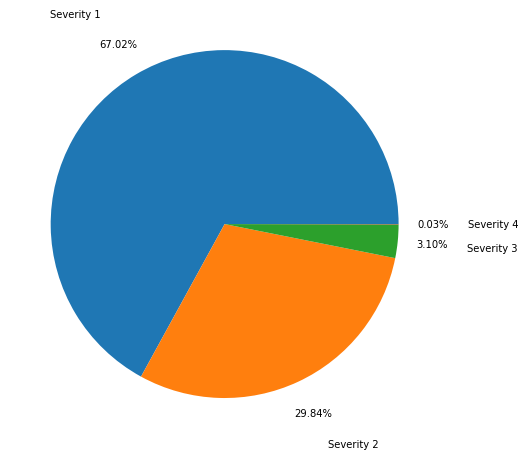

In [0]:
c = df.Severity.value_counts(dropna=False)
p = df.Severity.value_counts(dropna=False, normalize=True) * 100
per = pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %'])
labels = ['Severity 1',  'Severity 2', 'Severity 3',  'Severity 4']
fig, ax = plt.subplots()
ax.pie(per['Podiel v %'], labels=labels, autopct='%1.2f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)

plt.show()

Tu vidíme, že zastúpenie jednotlivých tried je značne **nerovnomerné**, jedna z nich je dokonca takmer zanedbateľná. Je možné, že bude potrebné vylúčiť záznamy s hodnotou tohto atribútu rovnou *1*. Dobré však je, že v prípade tohto atribútu nemajú **žiadne** záznamy **chýbajúce hodnoty**.

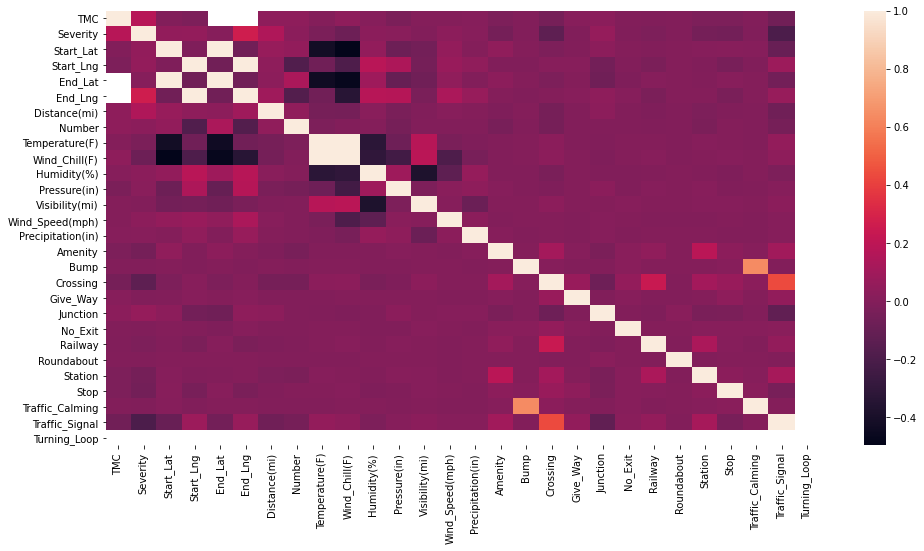

In [0]:
sns.heatmap(df.corr())

Vidíme, že existuje korelácia, aj keď nie značná, medzi atribútmi Temperature(F), Humidity(%) a Wind_Chill(F).

## Zaujímavé atribúty
Ďalej popíšeme zaujímavé atribúty, ktoré považujeme za kľúčové v rámci našej úlohy. Vo všeobecnosti považujeme za kľúčové atribúty popisujúce počasie v čase nehody. Jedná sa samozrejme len o náš odhad, a v neskorších fázach sa môžu ukázať významnými iné atribúty. Samostatnou kategóriou je závislá premenná, ktorej hodnoty bude náš model predikovať.

### Wind_Direction

Atribút *Wind_Direction*, teda smer vetra, popisuje nameraný smer vetra počas merania časovo aj priestorovo najbližšieho k danej nehode. Atribút je **kategorický**, kategória je popísaná reťazcom znakov.

In [0]:
df.Wind_Direction.nunique()

24

Vidíme, že tento atribút má 24 rôznych unikátnych hodnôt. Pozrime sa na konkrétne hodnoty a ich frekvenciu výskytu.

In [0]:
c = df.Wind_Direction.value_counts(dropna=False)
p = df.Wind_Direction.value_counts(dropna=False, normalize=True) * 100
pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %'])

,Počet,Podiel v %
Calm,368268,12.38
South,177222,5.96
West,164621,5.53
North,153246,5.15
SSW,152177,5.12
WNW,145355,4.89
SW,143801,4.83
SSE,138774,4.67
NW,137640,4.63
WSW,137543,4.62


Tu vidíme, že smer vetra sa skladá z jedného jednoduchého(*S,N,E,W*) alebo zložitého smeru(*NE, SE, NW, SW*), prípadne z dvojice týchto hodnôt.
Špeciálnymi prípadmi sú premenlivý vietor (*Variable*) a pokojné povetrie (*Calm*).

Tiež vidíme, že v niektorých prípadoch údaje merania nie sú dostupné (*NaN*). Tieto **chýbajúce záznamy** bude vo fáze predspracovania dát potrebné vylúčiť. Takýchto záznamov je 45101, čo v datasete s takmer 3 miliónmi záznamov tvorí približne 1,5% záznamov. Ich vylúčením sa tak použiteľná časť datasetu zmenší na 2929234 záznamov (bez uvažovania odstránenia záznamov z pohľadu iných atribútov).

 Tiež je potrebné povšimnúť si **nekonzistentný formát** niektorých hodnôt. Tie bude potrebné vo fáze predspracovania dát upraviť. Južný vietor je zapísaný dvomi rôznymi spôsobmi - *South* a *S*. Podobne je to u severného, východného a západného. Premenlivý vietor a pokojné povetrie sú tiež zapísané dvoma spôsobmi. V skratke bude teda potrebné vykonať zmeny:


*   North    ->  N
*   South    ->  S
*   West     ->  W
*   East     ->  E
*   Variable ->  VAR
*   Calm     ->  CALM.

Zmeny môžu byť vykonané aj opačným smerom.

Frekvenčné rozloženie hodnôt možno považovať za **pomerne rovnomerné** (najmä s predpokladom budúceho odstránenia nekonzistencie). Jediný **dominantný výskyt** je u triedy *Calm*(v budúcnosti agregovanou s *CALM*), s výskytom v 17% záznamov.

### Wind_Speed

Rýchlosť vetra v *mph*, zachytená atribútom *Wind_Speed*, je **numerický** atribút vyjadrený reálnym číslom.

Zistime, koľko záznamov nemá tento údaj uvedený.

In [0]:
df['Wind_Speed(mph)'].isnull().sum()

440840

Hodnota atribútu *Wind_Speed* chýba u 440840 záznamov, čo predstavuje približne 14,7% záznamov datasetu. Tieto záznamy bude pravdepodobne potrebné vylúčiť z datasetu.

Sledujme rozdelenie hodnôt tohto atribútu.

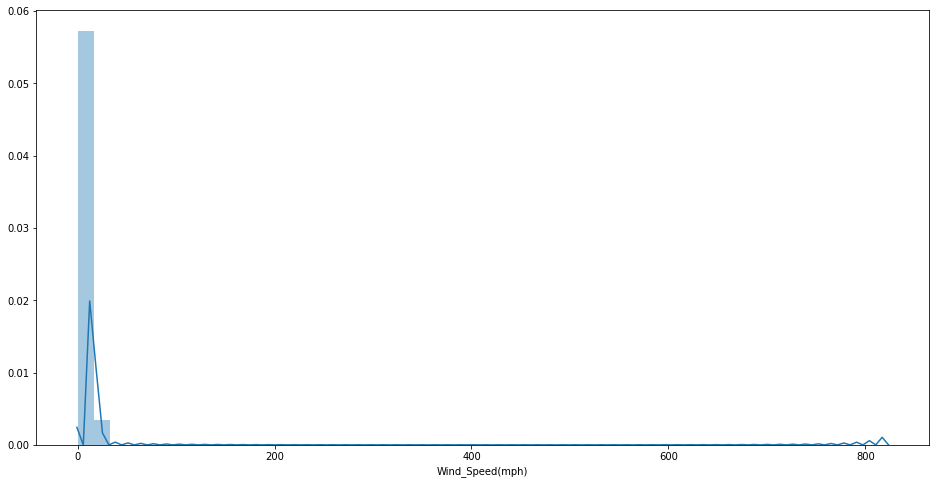

In [0]:
sns.distplot(df['Wind_Speed(mph)'])

Vidíme, že atribút *Wind_Speed* je v určitom intervale hodnôt pomerne rovnomerne rozdelený, avšak po určitom prahu sú jeho hodnoty **značne vychýlené** a sú v menšine.

Ak nastavíme prah hodnoty na 100, stále máme množstvo ojedinelých vychýlených hodnôt.

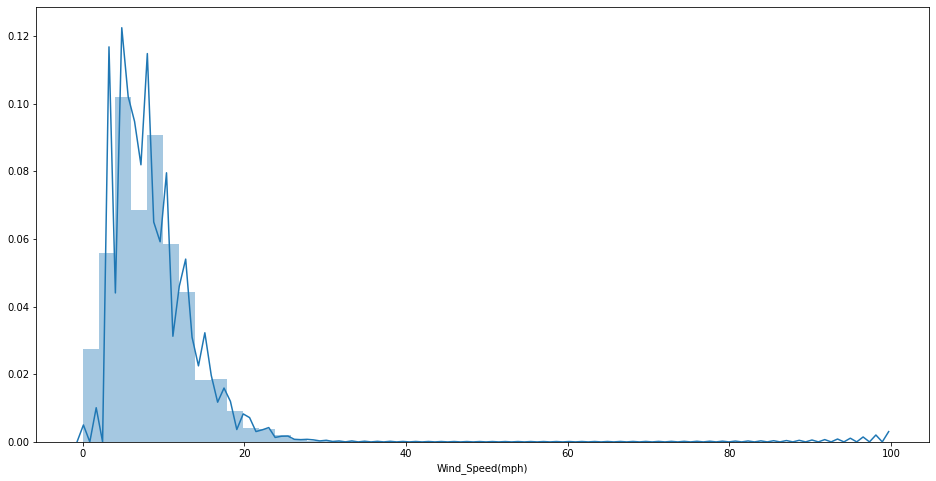

In [0]:
sns.distplot(df[df['Wind_Speed(mph)'] < 100]['Wind_Speed(mph)'])

S prahom hodnoty atribútu nastaveným na 40, rozdelenie je oveľa rovnomernejšie. Zdá sa, že ak povolíme len záznamy s hodnotou *Wind_Speed* pod 40, získame podmnožinu datasetu bez vychýlených hodnôt, takzvaných *outliers*.

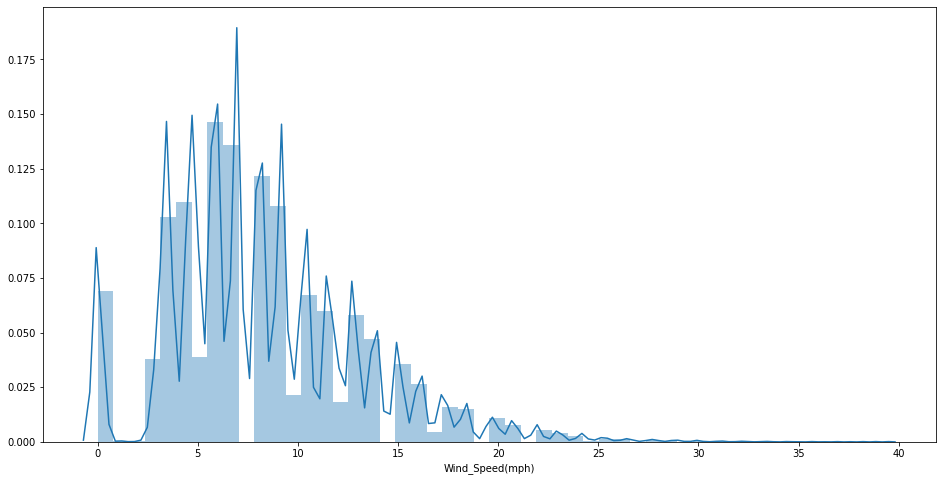

In [0]:
sns.distplot(df[df['Wind_Speed(mph)'] < 40]['Wind_Speed(mph)'])

Pravdepodobne bude potrebné záznamy s vychýlenými hodnotami vylúčiť z datasetu.

### Wind_Chill

Atribút *Wind_Chill* popisuje ochladenie tela spôsobované aktuálnym vetrom, vyjadrené na strupnici *Fahrenheita*. Jedná sa o **numerický atribút** vyjadrený reálnym číslom.

Zistime, či sú v datasete záznamy bez tohto údaju.

In [0]:
df['Wind_Chill(F)'].isnull().sum()

1852623

Hodnota tohto atribútu chýba u takmer 2 miliónov záznamov, čo je približne 62% datasetu. Indikuje to možnú potrebu vylúčenia tohto atribútu.

Pozrime sa na rozdelenie hodnôt tohto atribútu.

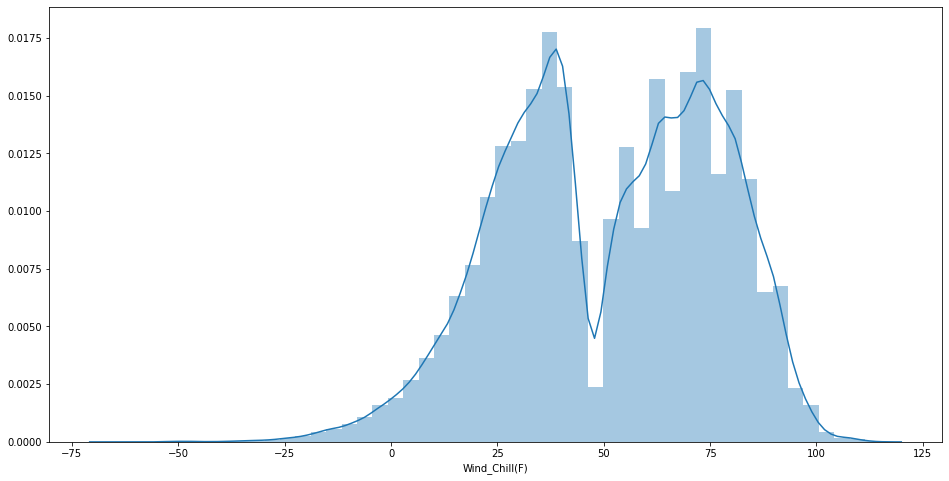

In [0]:
sns.distplot(df['Wind_Chill(F)'])

Okrem výrazného poklesu v strede, rozdelenie hodnôt tohto atribútu sa nápadne podobá normálnemu rozdeleniu, vďaka čomu by nebolo potrebné ďalej vylučovať záznamy na základe tohto atribútu.

Nevýhodou tohto atribútu je **množstvo chýbajúcich hodnôt**, čo by v prípade použitia tohto atribútu vylúčilo približne 62% datasetu. Jeho výhodou však je rozdelenie hodnôt **blížiace sa normálnemu rozdeleniu**.

### Visibility(mi)

Atribút *Visibility* vyjadruje viditeľnosť na ceste v míľach. Jedná sa o **numerický** atribút vyjadrený reálnym číslom.

Zistime, či dataset obsahuje záznamy bez uvedenej hodnoty tohto atribútu.

In [0]:
df['Visibility(mi)'].isnull().sum()

65691

Takýchto záznamov je 65691, čo predstavuje približne 2% datasetu. Vylúčením týchto záznamov sa teda dataset významne nezredukuje.

Pozrime sa na rozdelenie hodnôt tohto atribútu.

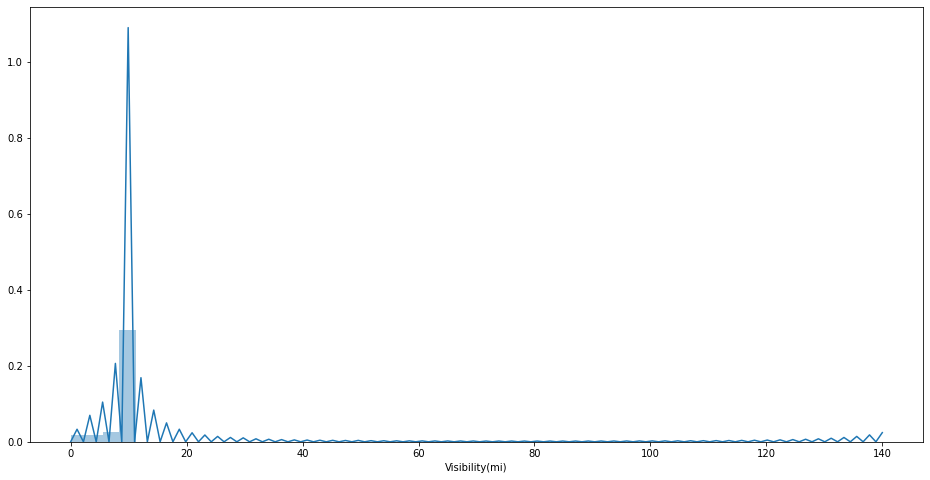

In [0]:
sns.distplot(df['Visibility(mi)'])

Môžeme pozorovať podobné správanie ako u atribútu *Wind_Speed*. Hodnoty atribútu *Visibility* sa správajú podobne ako normálne rozdelenie okolo určitej hodnoty, avšak **niektoré hodnoty sú výrazne vychýlené**. Pokúsme sa preto extrémne hodnoty vylúčiť.

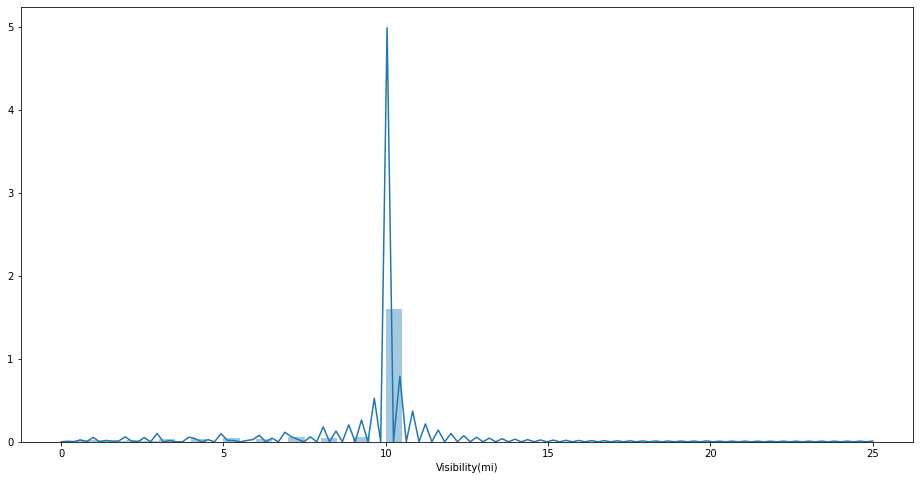

In [0]:
sns.distplot(df[df['Visibility(mi)'] < 30]['Visibility(mi)'])

Hoci výsledná podmnožina datasetu rastie a klesá oveľa ostrejšie ako normálne rozdelenie, dostatočne sa k nemu blíži. Preto bude opäť potrebné vylúčiť vychýlené hodnoty, ak chceme použiť tento atribút.

### Weather_Condition

Atribút *Weather_Condition* predstavuje popis počasia. Jedná sa o **kategorický** atribút vyjadrený reťazcom znakov. 

In [0]:
df.Weather_Condition.nunique()

120

Môžeme pozorovať, že nadobúda 120 rôznych hodnôt. Pozrime sa na početnejšiu polovicu tried.

In [0]:
c = df.Weather_Condition.value_counts(dropna=False)
p = df.Weather_Condition.value_counts(dropna=False, normalize=True) * 100
pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %']).head(60)

,Počet,Podiel v %
Clear,808171,27.17
Mostly Cloudy,412528,13.87
Overcast,382480,12.86
Fair,335289,11.27
Partly Cloudy,295439,9.93
Scattered Clouds,204662,6.88
Light Rain,141073,4.74
Cloudy,115496,3.88
NaN,65932,2.22
Light Snow,42123,1.42


A teraz pozorujme menej početnú polovicu tried.

In [0]:
pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %']).tail(60)

,Počet,Podiel v %
Blowing Dust,44,0.00
Small Hail,30,0.00
Light Drizzle / Windy,28,0.00
Sand / Dust Whirlwinds,27,0.00
Squalls,26,0.00
Light Snow Showers,24,0.00
Heavy Snow / Windy,23,0.00
Volcanic Ash,22,0.00
Light Thunderstorms and Snow,22,0.00
Wintry Mix / Windy,20,0.00


Zastúpenie tried je veľmi nerovnomerné. Ponúkajú sa teda 3 možnosti:


1.   **Vylúčenie tried** so zastúpením pod prahovou hodnotou
2.   **Zlúčenie tried** s nízkym zastúpením pod *Other* hodnotu
3.   **Zlúčenie tried** s nízkym zastúpením do väčších tried - napríklad všetky triedy obsahujúce text *snow* alebo *ice* zlúčené do jednej triedy *winter-specific conditions* a podobne.



Ako daľšie sme sa pozreli na to, aký vplyv majú poveternostné podmienky na závažnosť nehody.

In [0]:
w_cond = df.Weather_Condition.dropna().value_counts()

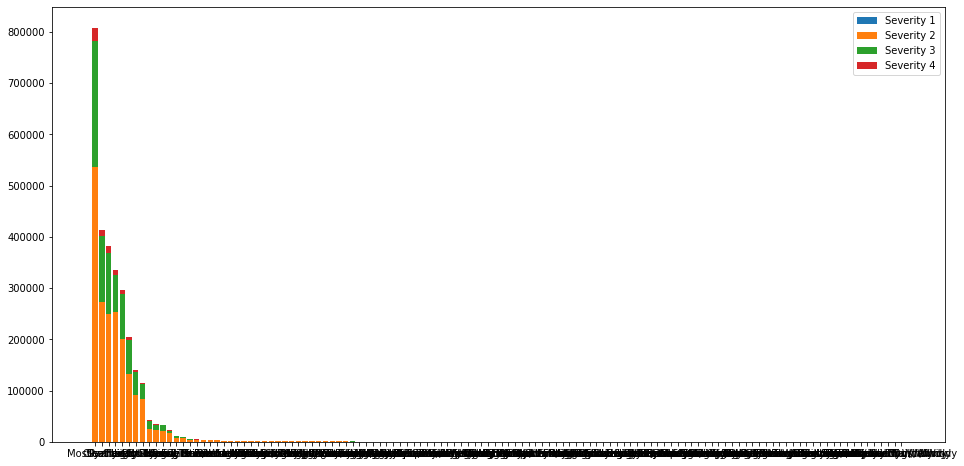

In [9]:
severity_1_by_Weather = []
severity_2_by_Weather = []
severity_3_by_Weather = []
severity_4_by_Weather = []

for cond in w_cond.index:
    severity_1_by_Weather.append(df[(df['Severity']==1)&(df['Weather_Condition']==cond)].count()['Weather_Condition'])
    severity_2_by_Weather.append(df[(df['Severity']==2)&(df['Weather_Condition']==cond)].count()['Weather_Condition'])
    severity_3_by_Weather.append(df[(df['Severity']==3)&(df['Weather_Condition']==cond)].count()['Weather_Condition'])
    severity_4_by_Weather.append(df[(df['Severity']==4)&(df['Weather_Condition']==cond)].count()['Weather_Condition'])

plt.bar(w_cond.index, severity_1_by_Weather, label='Severity 1')
plt.bar(w_cond.index, severity_2_by_Weather, label='Severity 2', bottom = severity_1_by_Weather)
plt.bar(w_cond.index, severity_3_by_Weather, label='Severity 3', bottom = [i+j for i,j in zip(severity_1_by_Weather, severity_2_by_Weather)])
plt.bar(w_cond.index, severity_4_by_Weather, label='Severity 4', bottom = [i+j+k for i,j,k in zip(severity_1_by_Weather, severity_2_by_Weather, severity_3_by_Weather)])
plt.legend()

Je vidieť, že špecifické poveternostné podmienky majú dopad na závažnosť nehody.
Keď odignorujeme riadky, ktoré sú jednoznačne najčastejšími podmienkami, tak možme vidieť aj vplyv menej častých poveternostných podmienok.

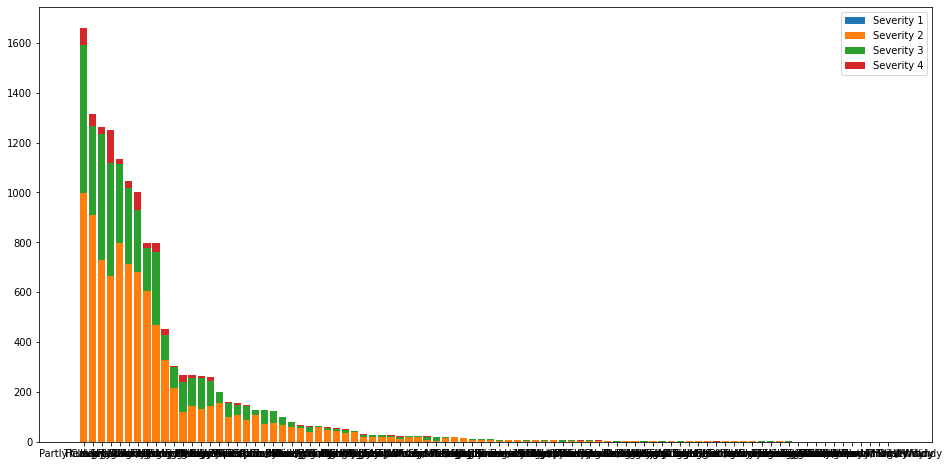

In [13]:
plt.bar(w_cond.index[30:], severity_1_by_Weather[30:], label='Severity 1')
plt.bar(w_cond.index[30:], severity_2_by_Weather[30:], label='Severity 2', bottom = severity_1_by_Weather[30:])
plt.bar(w_cond.index[30:], severity_3_by_Weather[30:], label='Severity 3', bottom = [i+j for i,j in zip(severity_1_by_Weather[30:], severity_2_by_Weather[30:])])
plt.bar(w_cond.index[30:], severity_4_by_Weather[30:], label='Severity 4', bottom = [i+j+k for i,j,k in zip(severity_1_by_Weather[30:], severity_2_by_Weather[30:], severity_3_by_Weather[30:])])
plt.legend()

### Temperature

Je **numerický atribút** , ktorý vyjadruje teplotu v čase nehody (vo Fahrenheitoch). Sledujme, či nemá výrazný počet chýbajúcich hodnôt.

In [0]:
df['Temperature(F)'].isnull().sum()

56063

Chýba v približne 2% datasetu, čo nie je značný problém.

Pozrime sa na rozdelenie hodnôt tohto atribútu.

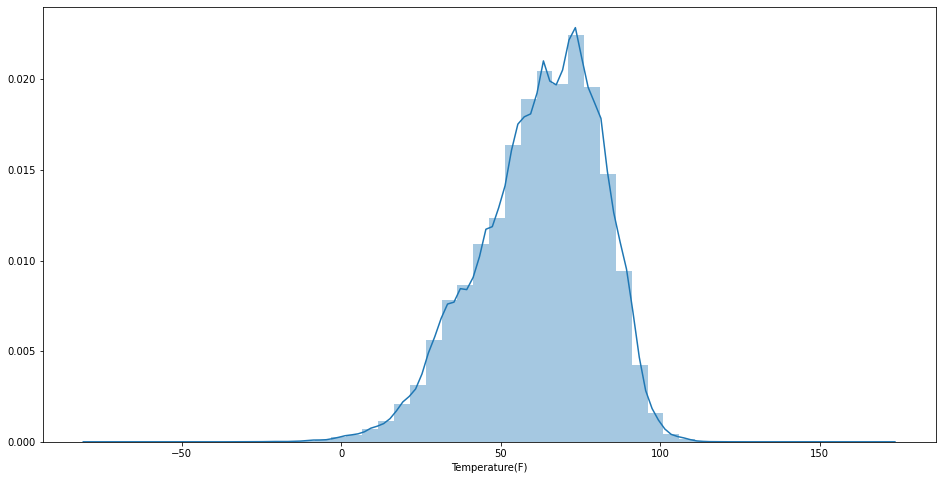

In [0]:
sns.distplot(df['Temperature(F)'])

Môžeme pozorovať, že rozdelenie hodnôt tohto atribútu sa podobá normálnemu rozdeleniu.

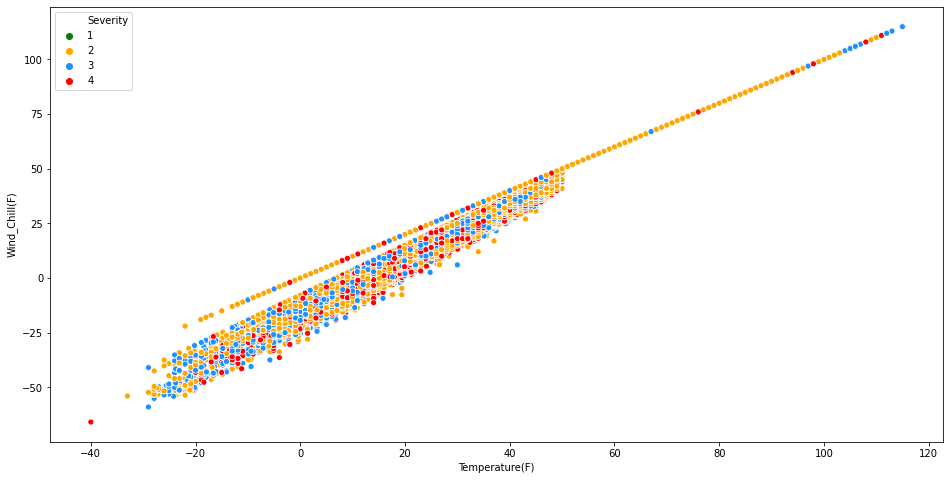

In [0]:
sns.scatterplot(y=df['Wind_Chill(F)'], x=df['Temperature(F)'], hue=df['Severity'],  palette=['green','orange','dodgerblue','red'])

Z grafu možme pozorovať, že existuje závislosť medzi teplotou a ochladením prostredníctvom vetra.

### Humidity

**Numerický atribút**, ktorý vyjadruje vlhkosť (v percentách). Sledujme, u koľkých záznamov chýba jeho hodnota.


In [0]:
df['Humidity(%)'].isnull().sum()

59173

Pozrime sa na rozdelenie hodnôt tohto atribútu.

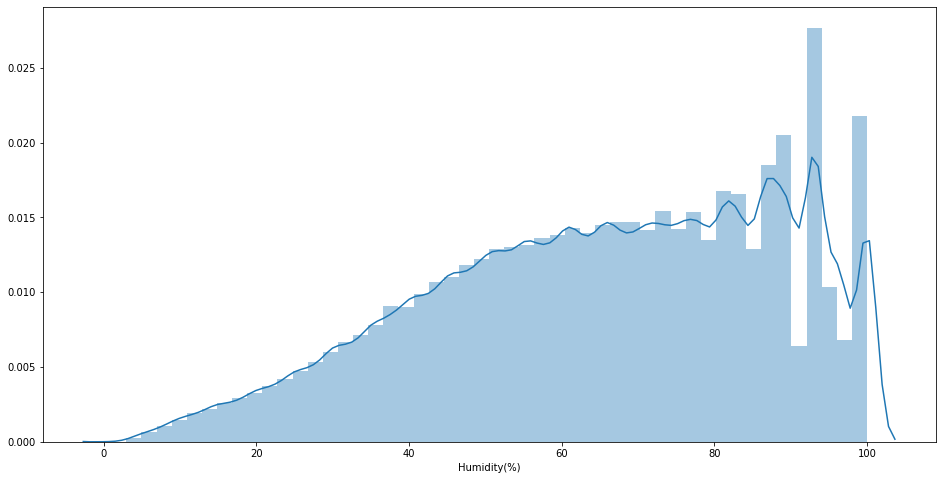

In [0]:
sns.distplot(df['Humidity(%)'])

Môžeme pozorovať, že rozdelenie sa **podobá normálnemu rozdelieniu**, i keď je trochu "sploštené". Samozrejme, aj krajné hodnoty pohybujúce sa okolo hodnôt 80 až 100% predstavujú výkyv od normálneho rozdelenia.

### Latitude a Longtitude

Zobrazujú zemepisnú šírku a dĺžku v GPS súradniciach východiskového a koncového bodu.

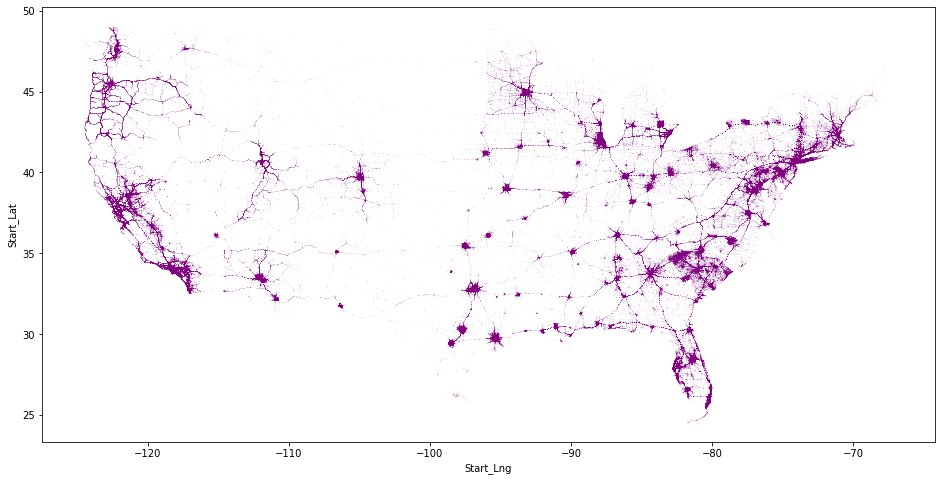

In [0]:
plt.xlabel('Start_Lng')
plt.ylabel('Start_Lat')
plt.plot(df.Start_Lng, df.Start_Lat, ".",color="purple", alpha=0.2, ms=0.1)
plt.show()

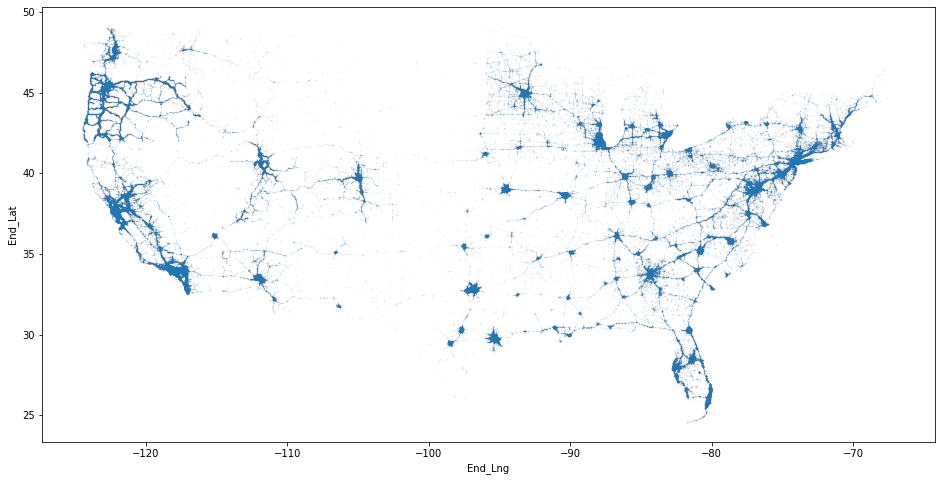

In [0]:
plt.xlabel('End_Lng')
plt.ylabel('End_Lat')
plt.plot(df.End_Lng, df.End_Lat, ".",marker="o", alpha=0.2, ms=0.1)
plt.show()

Z grafov vyššie možme pozorovať ohniská dopravných nehôd, ktoré sú najčastejšie v blízkosti veľkých miest USA.

### Start a End time


Z údajov o čase začiatku a koncu dopravnej nehody sme si vyrobili nový atribút - doba trvania dopravnej nehody. Tento nový údaj nám môže v budúcnosti pomôcť s našou úlohou, ktorou je predikovanie závažnosti dopravnej nehody. 

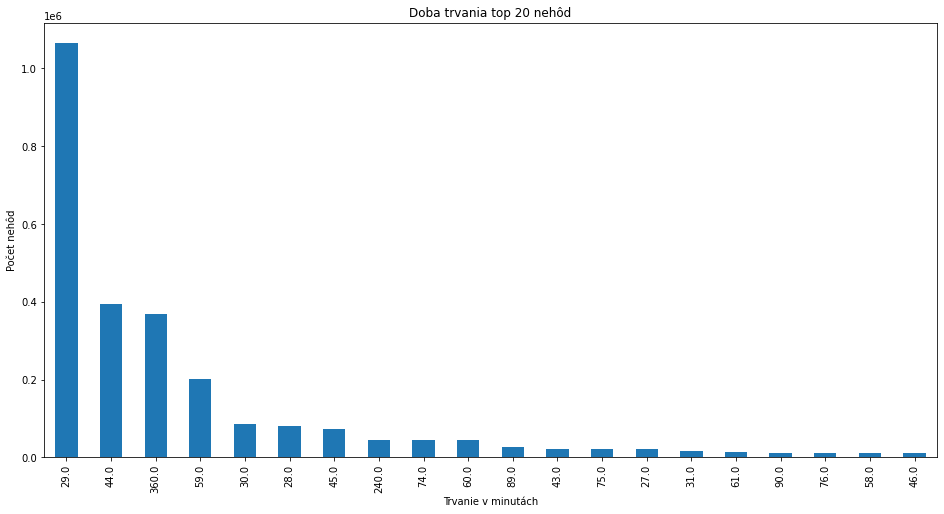

In [0]:
duration = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
top = duration.astype('timedelta64[m]').value_counts().nlargest(20)
plt.title('Doba trvania top 20 nehôd')
plt.xlabel('Trvanie v minutách')
plt.ylabel('Počet nehôd')
top.plot(kind='bar')

Graf vyššie zobrazuje top 20 časov trvania v minútach dopravných nehôd. Pozorujeme, že najviac dopravných nehôd trvá necelých 30 minút. 

# Identifikácia problémov

Ako odhalila analýza dát, najmä u zaujímavých atribútov, v datasete sa vyskytuje viacero záznamov s **chýbajúcimi hodnotami** v rôznych atribútoch. Ak pristúpime k vylúčeniu týchto záznamov, môže nastať situácia, že zostávajúca podmnožina datasetu nebude dostatočne veľká a rozmanitá pre trénovanie modelu.

Viaceré atribúty majú veľmi **nerovnomernú distribúciu** hodnôt, v dôsledku čoho môžu byť nepoužiteľné pre predikčný model, alebo neprispievať k predikovanej hodnote. Jedná sa najmä o boolovské atribúty indikujúce prítomnosť rôznych infraštrukturálnych prvkov v blízkosti nehody, akými sú spomaľovač, križovatka alebo kruhový objazd.

Medzi niektorými atribútmi existuje **závislosť**. Napríklad ak pre daný záznam poznáme mesto, atribút štát predstavuje duplicitnú informáciu, pretože z mesta dokážeme určiť štát. V tomto prípade budeme musieť atribúty vylúčiť, alebo transformovať. Tiež je možné zamerať sa na dominatnú triedu v jednom z atribútov, a pracovať so záznamami len z tejto triedy, napr. pracovať len so záznamami z jednej krajiny.

Pozrime sa na to, koľko záznamov by v datasete ostalo, ak odstránime všetky záznamy obsahujúce ktorýkoľvek z identifikovaných problémov a zároveň sa zameriame len na krajinu s najväčším počtom nehôd, ktorou je *California*(pesimistická verzia). Vypisované sú hodnoty po každej podmienke, výsledná veľkosť datasetu je posledná hodnota.

In [15]:
df_reduced = df
df_reduced = df_reduced[df_reduced['Wind_Speed(mph)'] < 40] # this removes extreme and null values
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced.Wind_Direction.notna()] # remove null values of wind direction
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced['Wind_Chill(F)'].notna()] # remove null values of wind chill
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced['Visibility(mi)'] < 30] # this removes extreme and null values
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced['Weather_Condition'].notna()] # remove null values of Weather_Condition
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced.groupby("Weather_Condition")["Weather_Condition"].transform(len)/len(df_reduced.index)*100 > 1] # this removes classes with less than 1% frequency
print(len(df_reduced.index))
df_reduced = df_reduced[df_reduced['State'] == 'CA'] # If we only focus on California
print(len(df_reduced.index))

2533172
2533148
1121527
1114685
1112440
1058646
181262


Pozrime sa na rozdelenie jednotlivých tried závažnosti (závislej premennej) v takto okresanom datasete.

In [0]:
c = df_reduced.Severity.value_counts(dropna=False)
p = df_reduced.Severity.value_counts(dropna=False, normalize=True) * 100
perc = pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %'])

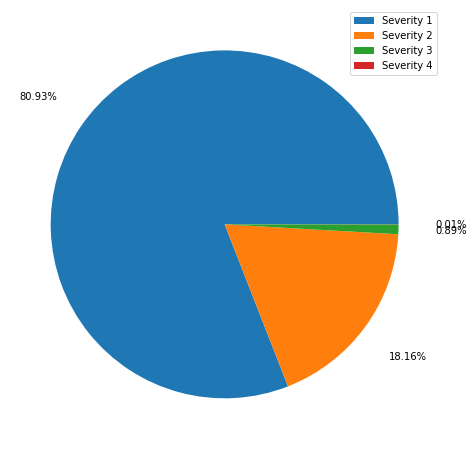

In [17]:
labels = ['Severity 1',  'Severity 2', 'Severity 3',  'Severity 4']
fig, ax = plt.subplots()
ax.pie(perc['Podiel v %'],  autopct='%1.2f%%', pctdistance=1.3)
plt.legend(labels)
plt.show()

Vidíme, že rozdelenie je značne nerovnomerné, dve triedy sú zastúpené úplne minimálne. To si môže vyžiadať zmeniť kritériá vylučovania záznamov. Rozdelenie sa značne zhoršilo v porovnaní s neprečisteným datasetom. Uvádzame jeho rozdelenie nižšie, pre porovnanie.

In [0]:
c = df.Severity.value_counts(dropna=False)
p = df.Severity.value_counts(dropna=False, normalize=True) * 100
per1 = pd.concat([c,p], axis=1, keys=['Počet', 'Podiel v %'])

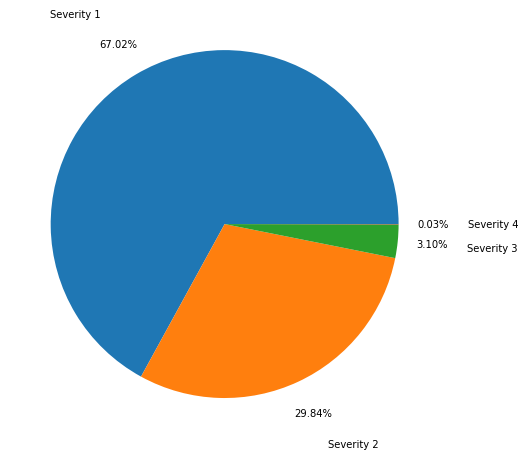

In [19]:
labels = ['Severity 1',  'Severity 2', 'Severity 3',  'Severity 4']
fig, ax = plt.subplots()
ax.pie(per1['Podiel v %'], labels=labels, autopct='%1.2f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)

plt.show()

# Scenár riešenia

V tejto časti popíšeme predpokladaný scenár riešenia úlohy na vyššej úrovni abstrakcie.
###  1. Identifikácia úlohy
Najskôr je potrebné stanoviť, aký problém bude projekt riešiť a zadefinovať úlohu. Z úvodu tohto dokumentu vyplynulo, že v rámci projektu sa pokúsime určiť závažnosť dopravnej nehody na 4-bodovej stupnici z vlastností danej nehody. Úlohu sme zadefinovali ako **klasifikáciu**, avšak nevylučujeme jej možné neskoršie predefinovanie na regresiu, keďže je možné ju riešiť oboma prístupmi.
Tiež je vhodné nájsť v tejto fáze vhodný dataset a získať k nemu prístup. V rámci tejto fázy sme sa rozhodli pracovať s datasetom **US Accidents** [2], ktorý je voľne dostupný.
###  2. Analýza dát
Dataset je následne potrebné analyzovať, aby sme poznali jeho vlastnosti a obmedzenia. Dôležitým výstupom je identifikácia problémových atribútov či záznamov, a načrtnutie možných riešení. Už teraz sme objavili **chýbajúce hodnoty atribútov**, **nekonzistentný formát**,**ich nerovnomernú distribúciu** či **vzájomnú závislosť**.
###  3. Predspracovanie dát
V tejto fáze hlbšie preskúmame identifikované problémy datasetu, a podnikneme kroky pre ich napravenie. V niektorých prípadoch vylúčime nepotrebné a nevhodné atribúty (ako *ID* alebo *State*). Tiež **odstránime záznamy** s chýbajúcimi hodnotami niektorých atribútov. Zároveň pravdepodobne zredukujeme počet záznamov tým, že sa zameriame len na jednu krajinu. Bude potrebné aj **napraviť nekonzistenciu** formátu hodnôt niektorých atribútov, medzi ktoré patrí *Wind direction*. Predpokladáme, že po vykonaní týchto krokov odhalíme nové problémy, ako napríklad distribúcia hodnôt atribútov v danej podmnožine datasetu.
###  4. Transformácia dát
V tejto fáze preskúmame možnosti zmeny existujúcich atribútov, teda ich **zlúčenie**, **úpravu typu** alebo **agregáciu tried**. V tejto chvíli nie sú jasné konkrétne kroky.

Možnou úpravou je napríklad zlúčenie atribútov *Start_Time* a *End_Time* do jedného atribútu *Duration*. Tiež sa z nich dá vyvodiť časť dňa (ráno, predpoludnie, poludnie, ...), mesiac, ročné obdobie alebo či sa jednalo o prestupný rok.

Ďalšou možnosťou je z atribútov *Start/End_Lat/Long* určiť dĺžku nehody. Problémom však je, že koncové koordináty chýbajú v 76% záznamov datasetu.

Z tohto pohľadu spočíva veľký potenciál najmä v atribúte *Weather_Condition*, z ktorého sa dajú vyvodiť ďalšie atribúty typu boolean, ako *Snow*, *Rain* a podobne.

Podobne sa dá využiť atribút *Description*, z ktorého sa dá vyvodiť, či došlo k zablokovaniu/uzavretiu jazdného pruhu (kľúčové slová "blocked"/"closed"), či sa dali očakávať omeškania (kľúčová fráza "Expect delays"), či boli prechádzajúci varovaní (kľúčová fráza "Approach with care"), či došlo k vzpriečeniu nákladného vozidla (kľúčové slovo "jackknifed") a podobne.
###  5. Trénovanie základného modelu
Po príprave datasetu bude nutné **zvoliť vhodný model** vzhľadom na vlastnosti datasetu a charakter úlohy. Potom bude potrebné nájsť vhodnú **knižnicu** a **implementovať** model. Výstupom bude základný natrénovaný model.
###  6. Trénovanie finálneho modelu
Po vytvorení základného modelu bude potrebné **ladiť hyperparametre**, prípadne urobiť **novú iteráciu** cez úpravu dát, voľbu modelu až po nové ladenie hyperparametrov. V pesimistickom scenári bude potrebných viacero takýchto iterácií, v optimistickom bude táto fáza pozostávať najmä z ladenia hyperparametrov modelu.
###  7. Vyhodnotenie modelu
Dôležitou súčasťou projektu bude určenie toho, **ako bude model vyhodnocovaný**. Z povahy datasetu je zabezpečené, že **vieme objektívne posúdiť**, či je daná predikcia správna alebo nie, keďže dataset obsahuje závislú premennú ako jeden z atribútov.

##Referencie

[1] MELO, C.P. - GRAHAM, J.D. - BRAGE-ARDAO, R.
The productivity of transport infrastructure investment: A meta-analysis of empirical evidence.
In: *Regional Science and Urban Economics*. 2013. Vol. 43, no. 5, s. 695-706.

[2] MOOSAVI, S. US Accidents. https://www.kaggle.com/sobhanmoosavi/us-accidents.